In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Image and batch size
image_size = (128, 128)
batch_size = 10

# Paths
train_dir = r"C:\Users\PMLS\Desktop\project2.ipynb\rice_leaf_diseases\train"
test_dir = r"C:\Users\PMLS\Desktop\project2.ipynb\rice_leaf_diseases\test"

# Image data augmentation (aggressive)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())

Found 90 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


In [3]:
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [4]:
# Transfer Learning using MobileNetV2
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

In [5]:
# Compile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
# Train model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[early_stop]
)

c:\Users\PMLS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 733ms/step - accuracy: 0.3854 - loss: 1.5933 - val_accuracy: 0.4000 - val_loss: 1.8559
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 379ms/step - accuracy: 0.7153 - loss: 0.8873 - val_accuracy: 0.4667 - val_loss: 1.8665
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 351ms/step - accuracy: 0.8439 - loss: 0.4441 - val_accuracy: 0.5667 - val_loss: 1.5934
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - accuracy: 0.8615 - loss: 0.3306 - val_accuracy: 0.5667 - val_loss: 1.8231
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.8517 - loss: 0.3538 - val_accuracy: 0.5667 - val_loss: 2.1417
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 471ms/step - accuracy: 0.8363 - loss: 0.3348 - val_accuracy: 0.5333 - val_loss: 2.4802
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 429ms/step - accuracy: 0.9352 - loss: 0.2016 - val_accuracy: 0.5333 - val_loss: 2.1383
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - accuracy: 0.9303 - loss: 0.2294 - val_accuracy: 0.6000 - val_loss

In [8]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.6833 - loss: 1.2054
Test accuracy: 0.57


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


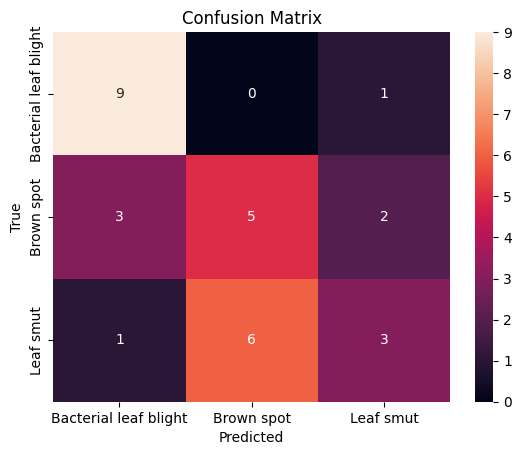

In [9]:

# Confusion matrix
preds = np.argmax(model.predict(test_generator), axis=1)
confusion_mtx = confusion_matrix(test_generator.classes, preds)
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [11]:
model.save("rice_leaf_model.h5")
print("Model saved as rice_leaf_model.h5")


Model saved as rice_leaf_model.h5
